In [ ]:
! pip install lamoom
! pip install lamoom_cicd
! pip install openai
! pip install pandas
! pip install python-dotenv

In [ ]:
import sys
sys.path.append('..')
import dotenv
dotenv.load_dotenv()
import pandas as pd

In [ ]:
from lamoom import Prompt


agent = Prompt("answer_on_medical_question")

agent.add("""Answer on medical question of the user:
{question}
          
Please first think out loud before answering.
""", role="system")


In [7]:
import os
from lamoom_cicd import TestLLMResponsePipe
openai_key = os.getenv("OPENAI_API_KEY")
claude_api_key = os.getenv("CLAUDE_API_KEY")
lamoom_pipe = TestLLMResponsePipe(openai_key=openai_key)
index = 0
from lamoom import Lamoom
client = Lamoom(openai_key=openai_key, claude_key=claude_api_key)

In [8]:
from lamoom.response_parsers.response_parser import get_json_from_response
from lamoom_cicd import TestLLMResponsePipe
lamoom_pipe = TestLLMResponsePipe()
results = []

In [9]:
data_df = pd.read_csv('./test_data/medical_questions_answers.csv')

In [ ]:
for index, row in data_df.iterrows():
    print(f"Processing row {index}")
    question = row['question']
    ideal_answer = row['answer']
    try:
        context = {
            'question': question,
            'ideal_answer': ideal_answer,
        }
        response = client.call(
            agent.id, context, 'openai/gpt-4o', 
            test_data={
                'ideal_answer': ideal_answer
            }
        )
        test_result = lamoom_pipe.compare(ideal_answer, response.content)
        lamoom_pipe.accumulated_results.append(test_result)
        results.append(test_result)
    except Exception as e:
        print(e)

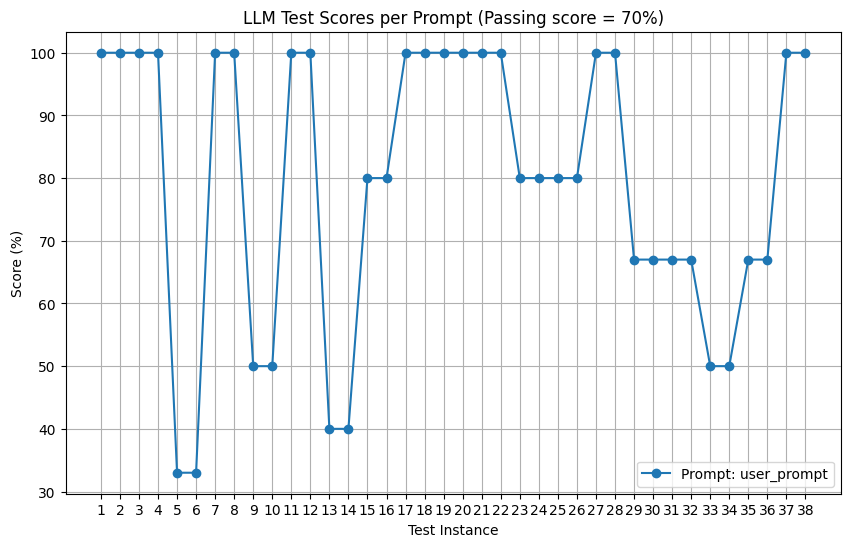

In [11]:
lamoom_pipe.visualize_test_results()

In [ ]:
for result in results:
    print('\n'.join([str(q.to_dict()) for q in result.questions]))
    print(result.questions[0].ideal_answer)
    print('\n\n')